# Autoencoder for MNIST in Pytorch Lightning
## Imports

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch

from torchvision import transforms
import pytorch_lightning as pl
from autoencoder.image_folder_dataset import ImageFolderDataset
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Setup TensorBoard

In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6005

# 1. The MNIST Dataset

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(p=0.5),
                #transforms.RandomPerspective(distortion_scale=0.2, p=0.25),
                transforms.ToPILImage(),
                transforms.ToTensor(),
                #transforms.RandomErasing(p=0.5),
                #transforms.Normalize(mean, std),
            ]
        )

transform = transforms.Compose([])

path = os.path.dirname(os.path.abspath(os.getcwd()))
mnist_root = os.path.join(path, "datasets", "mnist")

train = ImageFolderDataset(root=mnist_root,images='train_images.pt',labels='train_labels.pt',force_download=False,verbose=True,transform=transform)
val = ImageFolderDataset(root=mnist_root,images='val_images.pt',labels='val_labels.pt',force_download=False,verbose=True,transform=transform)
test = ImageFolderDataset(root=mnist_root,images='test_images.pt',labels='test_labels.pt',force_download=False,verbose=True,transform=transform)

# We also set up the unlabeled images which we will use later
unlabeled_train = ImageFolderDataset(root=mnist_root,images='unlabeled_train_images.pt',force_download=False,verbose=True,transform=train_transform)
unlabeled_val = ImageFolderDataset(root=mnist_root,images='unlabeled_val_images.pt',force_download=False,verbose=True,transform=transform)

Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
http://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
http://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
http://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
http://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
http://i2dl.vc.in.tum.de/static/data/mnist.zip


The dataset consists of tuples of 28x28 pixel PIL images and a label that is an integer from 0 to 9.

The shape of our greyscale images:  (28, 28)


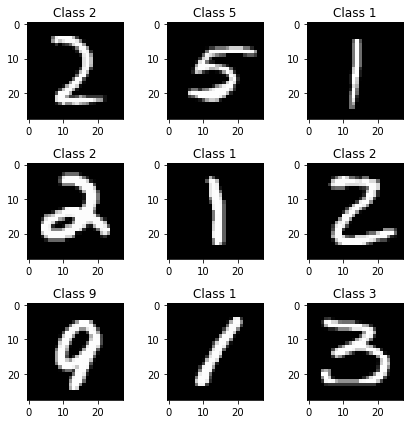

In [6]:
plt.rcParams['figure.figsize'] = (6,6)

for i in range(9):
    image = np.array(train[i][0].squeeze())
    label = train[i][1]
    plt.subplot(3,3,i+1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Class {}".format(label))

plt.tight_layout()
print('The shape of our greyscale images: ', image.shape)

# 2. A Simple Classifier

In [7]:
from autoencoder.models import Encoder
from autoencoder.models import Classifier

hparams = {
    "n_hidden_encoder": 520,
    "n_hidden_decoder": 256,
    "n_hidden": 256,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "weight_decay": 1e-5,
    "scheduler_factor": 0.1,
    "scheduler_patience": 1,
}

encoder = Encoder(hparams)
classifier = Classifier(hparams, encoder, train, val, test)

## 2.5 Fit Classification Model with Trainer

In [8]:
import copy
trainer = None

logger = TensorBoardLogger("lightning_logs")

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=30,
    verbose=False,
    mode="min",
)

trainer = pl.Trainer(
    weights_summary=None,
    profiler=False,
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else None,
    logger=logger,
    early_stop_callback=early_stop_callback
)

trainer.fit(classifier)
print("Validation accuracy when training from scratch: {}%".format(classifier.getAcc(classifier.val_dataloader())[1]*100))

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.
/Users/chloesekkat/Documents/TUM Courses/Intro to Deep Learning/I2DL_exercises/env/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
/Users/chloesekkat/Documents/TUM Courses/Intro to Deep Learning/I2DL_exercises/env/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
/Users/chloesekkat/Documents/TUM Courses/Intro to Deep Learning/I2DL_exercises/env/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val datal

/Users/chloesekkat/Documents/TUM Courses/Intro to Deep Learning/I2DL_exercises/env/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Validation accuracy when training from scratch: 45.0%


# 3. Autoencoder

![autoencoder](img/autoencoder.png)

![autoencoder_pretrained](img/pretrained.png)

In [33]:
from autoencoder.models import Autoencoder, Encoder, Decoder

hparams = {
    "n_hidden_encoder": 2048,
    "n_hidden_decoder": 1024,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "weight_decay": 1e-5
}

encoder_pretrained = Encoder(hparams)
decoder = Decoder(hparams)
ae_logger = TensorBoardLogger(save_dir='lightning_logs')
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder, unlabeled_train, unlabeled_val, ae_logger)

In [35]:
logger = TensorBoardLogger("lightning_logs")

early_stop_callback = EarlyStopping(
    monitor="train_loss",
    patience=5,
    verbose=False,
    mode="min",
)

ae_trainer = pl.Trainer(
    weights_summary=None,
    profiler=False,
    max_epochs=4,
    gpus=1 if torch.cuda.is_available() else None,
    logger=logger,
    #early_stop_callback=early_stop_callback
)

ae_trainer.fit(autoencoder)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.


Detected KeyboardInterrupt, attempting graceful shutdown...


1

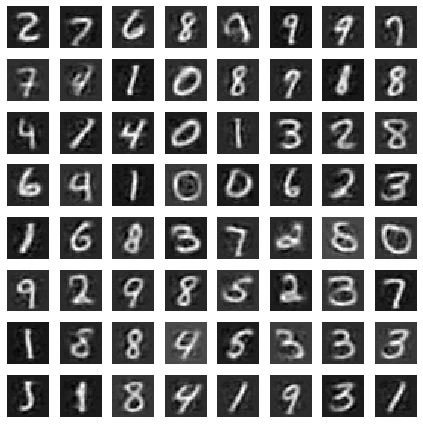

In [12]:
reconstructions = autoencoder.getReconstructions()
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.imshow(reconstructions[i], cmap='gray', interpolation='none')

plt.tight_layout()

# 4. Transfer Learning

## 4.1 The pretrained Classifier

Now we initialize another classifier but this time with the pretrained encoder.

In [13]:
from autoencoder.models import Classifier

hparams = {}

hparams = {
    "n_hidden": 2048,
    "batch_size": 32,
    "learning_rate": 1e-2,
    "weight_decay": 1e-5,
    "scheduler_factor": 0.001,
    "scheduler_patience": 2,
}

classifier_pretrained = Classifier(hparams, encoder_pretrained, train, val, test)

trainer = None

logger = TensorBoardLogger("lightning_logs")

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=50,
    verbose=False,
    mode="min",
)

trainer = pl.Trainer(
    weights_summary=None,
    profiler=False,
    max_epochs=300,
    gpus=1 if torch.cuda.is_available() else None,
    logger=logger,
    early_stop_callback=early_stop_callback
)

trainer.fit(classifier_pretrained)

In [15]:
print("Validation accuracy when training from scratch: {}%".format(classifier.getAcc(classifier.val_dataloader())[1]*100))
print("Validation accuracy with pretraining: {}%".format(classifier_pretrained.getAcc(classifier.val_dataloader())[1]*100))

Validation accuracy when training from scratch: 45.0%
Validation accuracy with pretraining: 72.0%


# Save model

In [16]:
from autoencoder.utils import save_model

print("Test accuracy when training from scratch: {}%".format(classifier.getAcc()[1]*100))
save_model(classifier_pretrained)

Test accuracy when training from scratch: 43.0%

Now to the pretrained classifier:
Validation-Accuracy: 72.0%
FYI: Your model has 1.712 mio. params.
Great! Your model size is less than 20 MB and will be accepted :)
Your model has been saved and is ready to be submitted. NOW, let's check the test-accuracy.
Test-Accuracy: 73.0%
